<a href="https://colab.research.google.com/github/JamesPeralta/NeuroNexus2019/blob/master/ModelTraining/Iteration3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount drive and download libraries from Github

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Any imports

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import cv2 
from sklearn.feature_extraction import image
import math
from keras.utils import np_utils
import keras

Using TensorFlow backend.


### Retrieve slices and thier ground-truth

In [3]:
# CD into the data
# CD into the data
t1 = '/content/drive/My Drive/#6_Brain_Segmentation/Scans/HC/HC_T1.nii'
c1 = '/content/drive/My Drive/#6_Brain_Segmentation/Scans/HC/c1HC_T1.nii'

t1_nii = nib.load(t1)
t1_np = np.array(t1_nii.dataobj)
print(t1_np.shape)

c1_nii = nib.load(c1)
c1_np = np.array(c1_nii.dataobj)
print(c1_np.shape)

(256, 256, 344)
(256, 256, 344)


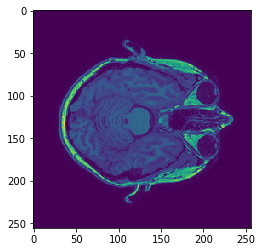

In [5]:
plt.imshow(t1_np[:, :, 108])

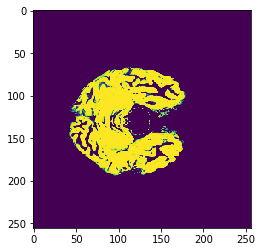

In [4]:
plt.imshow(c1_np[:, :, 108])

In [0]:
import sys
np.set_printoptions(threshold = sys.maxsize)
print(c1_np[:,:,108])

### Extract patches

In [18]:
t1_patches = image.extract_patches_2d(t1_np[108], (23, 23))
c1_patches = image.extract_patches_2d(c1_np[108], (23, 23))

print(t1_patches.shape)
print(c1_patches.shape)

(75348, 23, 23)
(75348, 23, 23)


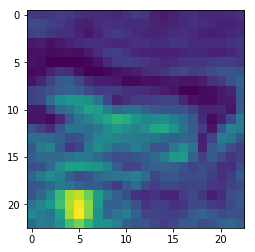

In [21]:
plt.imshow(t1_patches[40000])

In [19]:
x = t1_patches.reshape((75348, 23, 23, 1))
print(x.shape)

(75348, 23, 23, 1)


In [0]:
print(x[40000])

In [0]:
# Convert c1 patch to thier labels
y = label_patches(c1_patches)
y.shape

In [35]:
y.shape

(75348, 2)

In [0]:
zero_count = 0
one_count = 0
for i in y:
  if i[0] == 1:
    zero_count = zero_count + 1
    # Remove an index from 
  else:
    one_count = one_count + 1

In [45]:
print(zero_count)
print(one_count)

55911
19437


In [0]:
print(y[8823: 8850])

In [0]:
x_shuf = np.random.shuffle(x)
y_shuf = np.random.shuffle(y)

In [23]:
print(x.shape)
print(y.shape)

(75348, 23, 23, 1)
(75348, 2)


## Creating the Neural Network

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

In [0]:
# Define the models architecture
def create_model():
    # Build the architecture
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu', input_shape=(23, 23, 1), padding="same"))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding="same"))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=0.01), metrics=['acc'])
  
    return model

In [26]:
model = create_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 23, 23, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                204864    
_________________________________________________________________
dens

In [0]:
model.fit(x, y, batch_size=2, epochs=10, shuffle=True)

## Predict Batch and re-construct the image

In [0]:
this = np.array(model.predict_classes(x))

In [48]:
this.shape

(75348,)

In [0]:
print(this)

In [0]:
for i in this:
  if i == 1:
    print("Chill")

In [0]:
done = np.reshape(this, (234, 204))

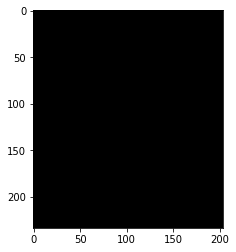

In [0]:
plt.imshow(done)

---
# Helpers

In [0]:
def label_patches(patches):
    '''
    Always pass in square patches with an odd width and height
    This is needed for use to calculate the center pixel

    :param patches: Patches you would like to label
    :return:
    '''
    labels_list = []
    dim = math.ceil(len(patches[0, 1, :]) / 2)

    for index, patch in enumerate(patches):
        if patch[dim, dim] > 0:
            labels_list.append("1")
            print("here" + str(index))
        else:
            labels_list.append("0")
          

    return keras.utils.to_categorical(labels_list, num_classes=2)